In [1]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import sys
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

DATA_LOCATION = "/work/mk423/Anxiety/"
UMC_PATH = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"

FLX_TRAIN_FILE = DATA_LOCATION + "FLX_train_dict_old_features.pkl"
FLX_VAL_FILE = DATA_LOCATION + "FLX_validation_dict_old_features.pkl"

EPM_TRAIN_FILE = DATA_LOCATION + "EPM_train_dict_May_17.pkl"
EPM_VAL_FILE = DATA_LOCATION + "EPM_val_dict_May_17.pkl"

OFT_TRAIN_FILE = DATA_LOCATION + "OFT_train_dict_old_features_hand_picked.pkl"
OFT_VAL_FILE = DATA_LOCATION + "OFT_validation_dict_old_features_hand_picked.pkl"

FEATURE_LIST = ['X_power_1_2','X_coh_1_2','X_gc_1_2']
FEATURE_VECTOR = FEATURE_LIST
FEATURE_WEIGHT = [10,1,1]



sys.path.append(UMC_PATH)
#from dCSFA_model import dCSFA_model
import umc_data_tools as umc_dt
from dCSFA_NMF import dCSFA_NMF

if torch.cuda.is_available():
    device="cuda:0"
else:
    device="cpu"


print("Using device: %s"%(device))

#For Consistency
RANDOM_STATE=42

import pandas as pd
def make_projection_csv(pickle_file,model,X_feature_list,other_features,save_file):

    with open(pickle_file,'rb') as f:
        project_dict = pickle.load(f)
    
    X_project = np.hstack([project_dict[feature] for feature in X_feature_list])
    s = model.transform(X_project)[3]
    s = s[:,0]
    save_dict = {}
    save_dict['scores'] = s
    for feature in other_features:
        save_dict[feature] = project_dict[feature]

    df = pd.DataFrame.from_dict(save_dict)
    df.to_csv(save_file,index=False,header=True)

    return df

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0


In [2]:
with open(OFT_TRAIN_FILE,'rb') as f:
    train_dict = pickle.load(f)

with open(OFT_VAL_FILE,'rb') as f:
    val_dict = pickle.load(f)

running_idx = 0
feature_groups = []
for idx,feature in enumerate(FEATURE_LIST):
    f_begin = running_idx
    f_end = f_begin + train_dict[feature].shape[1] 
    if idx == 0:
        f_end = f_end -1
    feature_groups.append((f_begin,f_end))

    running_idx = f_end

NUM_FREQS = 56
NUM_FEATURES = np.hstack([train_dict[feature] for feature in FEATURE_LIST]).shape[1] // NUM_FREQS
scale_vector = np.array([np.arange(1,NUM_FREQS+1) for feature in range(NUM_FEATURES)]).flatten()

#Train Arrays
oft_X_train = np.hstack([train_dict[feature]*weight for feature,weight in zip(FEATURE_LIST,FEATURE_WEIGHT)])#*scale_vector
#oft_X_train[np.isnan(oft_X_train)] = 0
#oft_X_train[oft_X_train<0] = 0
oft_y_hc_train = train_dict['y_Homecage'].astype(bool)
oft_y_task_train = ~oft_y_hc_train
oft_y_ROI_train = train_dict['y_ROI']
oft_y_vel_train = train_dict['y_vel']
oft_y_mouse_train = train_dict['y_mouse']
oft_y_time_train = train_dict['y_time']

#Validation Arrays
oft_X_val = np.hstack([val_dict[feature]*weight for feature,weight in zip(FEATURE_LIST,FEATURE_WEIGHT)])#*scale_vector
oft_y_hc_val = val_dict['y_Homecage'].astype(bool)
oft_y_task_val = ~oft_y_hc_val
oft_y_ROI_val = val_dict['y_ROI']
oft_y_vel_val = val_dict['y_vel']
oft_y_mouse_val = val_dict['y_mouse']
oft_y_time_val = val_dict['y_time']

oft_X = np.vstack([oft_X_train,oft_X_val])
oft_y_task = np.hstack([oft_y_task_train,oft_y_task_val])
oft_y_mouse = np.hstack([oft_y_mouse_train,oft_y_mouse_val])

In [3]:
with open(FLX_TRAIN_FILE,"rb") as f:
    flx_train_dict = pickle.load(f)

with open(FLX_VAL_FILE,"rb") as f:
    flx_validation_dict = pickle.load(f)

flx_X_train = np.hstack([flx_train_dict[feature]*weight for feature,weight in zip(FEATURE_LIST,FEATURE_WEIGHT)])
flx_y_train = flx_train_dict['y_flx']
flx_y_mouse_train = flx_train_dict['y_mouse']
flx_y_expDate_train = flx_train_dict['y_expDate']
flx_y_time_train = flx_train_dict['y_time']

flx_X_validation = np.hstack([flx_validation_dict[feature]*weight for feature,weight in zip(FEATURE_LIST,FEATURE_WEIGHT)])
flx_y_validation = flx_validation_dict['y_flx']
flx_y_mouse_validation = flx_validation_dict['y_mouse']
flx_y_expDate_validation = flx_validation_dict['y_expDate']
flx_y_time_validation = flx_validation_dict['y_time']

flx_X = np.vstack([flx_X_train,flx_X_validation])
flx_y_task = np.hstack([flx_y_train,flx_y_validation])
flx_y_mouse = np.hstack([flx_y_mouse_train,flx_y_mouse_validation])
flx_y_expDate = np.hstack([flx_y_expDate_train,flx_y_expDate_validation])
flx_y_time = np.hstack([flx_y_time_train,flx_y_time_validation])

In [4]:
with open(EPM_TRAIN_FILE,"rb") as f:
    epm_train_dict = pickle.load(f)

with open(EPM_VAL_FILE,"rb") as f:
    epm_validation_dict = pickle.load(f)
#Load the data
NUM_FREQS = 56
NUM_FEATURES = (epm_train_dict["X_power_1_2"].shape[1] + \
                epm_train_dict["X_coh_1_2"].shape[1] + \
                epm_train_dict["X_gc_1_2"].shape[1]) // NUM_FREQS
SCALE_VECTOR = np.array([np.arange(1,57) for feature in range(NUM_FEATURES)]).flatten()

X_train = np.hstack([epm_train_dict[feature]*weight for feature,weight in zip(FEATURE_LIST,FEATURE_WEIGHT)])
X_train[X_train<0] = 0
y_train = (epm_train_dict['y_ROI']%2).astype(bool)
y_in_task_mask_train = ~epm_train_dict['y_Homecage'].astype(bool)
y_mouse_train = epm_train_dict['y_mouse']
y_time_train = epm_train_dict['y_time']
train_nan_mask = (epm_train_dict['y_ROI'] > 0)


X_train_task = X_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_train_task = y_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_mouse_train_task = y_mouse_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_time_train_task = y_time_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
X_val = np.hstack([epm_validation_dict[feature]*weight for feature,weight in zip(FEATURE_LIST,FEATURE_WEIGHT)])


y_val = (epm_validation_dict['y_ROI']%2).astype(bool)
y_in_task_mask_val= ~epm_validation_dict['y_Homecage'].astype(bool)
y_mouse_val = epm_validation_dict['y_mouse']
y_time_val = epm_validation_dict['y_time']
val_nan_mask = (epm_validation_dict['y_ROI'] > 0)

X_val_task = X_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_val_task = y_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_mouse_val_task = y_mouse_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_time_val_task = y_time_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]

epm_X = np.vstack([X_train_task,X_val_task])
epm_y_task = np.hstack([y_train_task,y_val_task])
epm_y_mouse = np.hstack([y_mouse_train_task,y_mouse_val_task])
epm_y_time = np.hstack([y_time_train_task,y_time_val_task])


In [5]:
mt_X_train = np.vstack([flx_X_train,oft_X_train,X_train])
mt_y_train = np.hstack([flx_y_train,oft_y_task_train,y_in_task_mask_train])
mt_y_mouse_train = np.hstack([flx_y_mouse_train,oft_y_mouse_train,y_mouse_train])

mt_X_val = np.vstack([flx_X_validation,oft_X_val,X_val])
mt_y_val = np.hstack([flx_y_validation,oft_y_task_val,y_in_task_mask_val])
mt_y_mouse_val = np.hstack([flx_y_mouse_validation,oft_y_mouse_val,y_mouse_val])

intercept_mask = OneHotEncoder().fit_transform(mt_y_mouse_train.reshape(-1,1)).todense()

In [6]:
!pwd

/hpc/home/mk423/Anxiety/MultiTaskWork/Code


In [7]:
ADAMW_MODEL = ".\\Results-May-12\\{}_MT_Network_April_25.pt"
SGD_MODEL = ".\\{}_MT_Network_SGD_July_23.pt"
OLD_LOSS_MODEL = ".\\{}_MT_old_loss_SGD_July_24_5k_epoch_high_sup_recon_weight.pt"
HIGH_WEIGHT_SCALED_POWER = "../Models/{}_MT_10_res_loss_10_power_features.pt"
TEN_NETWORK_MODEL = ".\\{}_10_network_MT_model.pt"
N_COMPONENTS=20
DIM_IN = flx_X_train.shape[1]
NETWORK_CONSTRAINT = "Positive"
#model = dCSFA_NMF(n_components=N_COMPONENTS,dim_in=DIM_IN,device='auto',n_intercepts=intercept_mask.shape[1],
#                n_sup_networks=1,optim_name='SGD',recon_loss='MSE',sup_recon_weight=1,sup_weight=1,
#                useDeepEnc=True,h=256,sup_recon_type="Residual",feature_groups=feature_groups,fixed_corr=NETWORK_CONSTRAINT)
#model.fit(mt_X_train,mt_y_train,intercept_mask=intercept_mask,batch_size=128,lr=1e-3,
#        n_pre_epochs=100,n_epochs=1500,verbose=True,pretrain=True,best_model_name="{}_MT_SGD_Network_July_23_state_dict.pt".format(NETWORK_CONSTRAINT),
#        momentum=0.9)
#torch.save(model,HIGH_WEIGHT_SCALED_POWER.format(NETWORK_CONSTRAINT))
model = torch.load(HIGH_WEIGHT_SCALED_POWER.format(NETWORK_CONSTRAINT),map_location='cpu')
model.device='cpu'

In [97]:
def getReconContribution(X,n_components,model):
    perc_contribution_list = []
    EPSILON = 1e-6
    X_recon,_,_,s = model.transform(X)
    for component in range(n_components):
        X_recon_comp = model.get_comp_recon(s,component)
        perc_contribution = np.divide(X_recon_comp+EPSILON,X_recon+EPSILON)
        avg_perc_contribution = np.mean(perc_contribution,axis=0)

        perc_contribution_list.append(avg_perc_contribution)
    
    perc_contribution_mat = np.vstack(perc_contribution_list)
    return perc_contribution_mat


perc_contribution_train = getReconContribution(mt_X_train,20,model)
perc_contribution_val = getReconContribution(mt_X_val,20,model)
positive_mask = mt_y_val==1
perc_contribution_positive_labels = getReconContribution(mt_X_val[positive_mask==1],20,model)
perc_contribution_negative_labels = getReconContribution(mt_X_val[positive_mask==0],20,model)
np.savetxt("MT_train_network_perc_contribution.csv",perc_contribution_train)
np.savetxt("MT_val_network_perc_contribution.csv",perc_contribution_val)
np.savetxt("MT_val_network_perc_contribution_positive_labels.csv",perc_contribution_positive_labels)
np.savetxt("MT_val_network_perc_contribution_negative_labels.csv",perc_contribution_negative_labels)

In [96]:
np.savetxt("MT_train_network_perc_contribution.csv",perc_contribution_train)
np.savetxt("MT_val_network_perc_contribution.csv",perc_contribution_val)

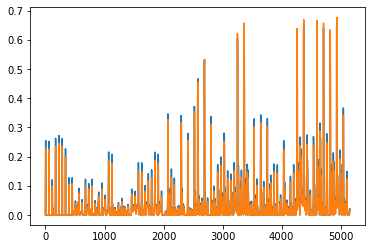

In [92]:
plt.plot(perc_contribution_train[0,:])
plt.plot(perc_contribution_val[0,:])
plt.show()

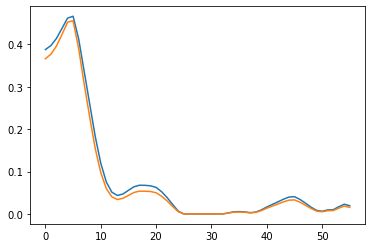

In [89]:
index = 46
plt.plot(perc_contribution_train[0,index*56:(index+1)*56])
plt.plot(perc_contribution_val[0,index*56:(index+1)*56])
plt.show()

In [33]:
perc_contribution_train.shape

(20, 39446)

In [19]:
s_train.shape

(39446, 20)

In [18]:
y_pred, s = model.predict(mt_X_train,include_scores=True)
np.sum(np.isnan(s))

788920

c:\Users\micha\Anaconda3\envs\cpne\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator NMF from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


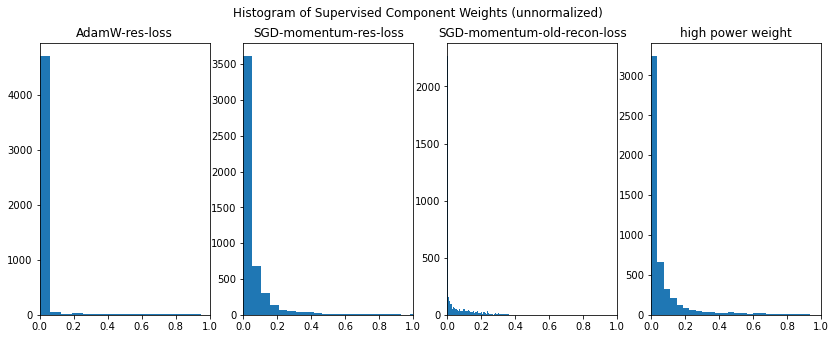

In [12]:
plt.figure(figsize=(14,5))
for idx,(model_name,model_optim) in enumerate(zip([ADAMW_MODEL,SGD_MODEL,OLD_LOSS_MODEL,HIGH_WEIGHT_SCALED_POWER],["AdamW-res-loss","SGD-momentum-res-loss","SGD-momentum-old-recon-loss","high power weight"])):
    model = torch.load(model_name.format(NETWORK_CONSTRAINT))
    model.device='cpu'
    components = model.get_W_nmf().cpu().detach().numpy()[0,:]
    plt.subplot(1,4,idx+1)
    plt.hist(components,bins=100)
    plt.title(model_optim)
    plt.xlim([0,1])

plt.suptitle('Histogram of Supervised Component Weights (unnormalized)')
plt.show()



In [18]:
model_name.format("Positive")

'.\\Positive_MT_10_res_loss_10_power_features.pt'

In [16]:
components = model.get_W_nmf().cpu().detach().numpy()

np.savetxt("MT_positive_electome_networks.csv",components)

In [13]:
model.device = "cuda"


In [13]:
y_pred, s = model.predict(mt_X_train,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,mt_y_train,mt_y_mouse_train)
print("Training ROC AUCs: ",roc_auc_dict)
mw_auc_dict = umc_dt.lpne_auc(y_pred,mt_y_train,mt_y_mouse_train,s,True)
print("Training Mann Whitney AUCs: ",mw_auc_dict)

y_pred, s = model.predict(mt_X_val,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,mt_y_val,mt_y_mouse_val)
print("Validation ROC AUCs: ",roc_auc_dict)
mw_auc_dict = umc_dt.lpne_auc(y_pred,mt_y_val,mt_y_mouse_val,s,True)
print("Validation MW AUCs: ",mw_auc_dict)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,


Training ROC AUCs:  {'auc_method': 'sklearn_roc_auc', 'Mouse04191': 1.0, 'Mouse04201': 0.9978354978354979, 'Mouse04202': 1.0, 'Mouse04205': 1.0, 'Mouse04215': 0.9924242424242424, 'Mouse0630': 0.9892205638474295, 'Mouse0634': 0.9728070175438597, 'Mouse0643': 0.9822485207100592, 'Mouse1551': 0.9846860643185298, 'Mouse3191': 0.9971605808303632, 'Mouse3192': nan, 'Mouse3193': 0.9976478084236595, 'Mouse3194': 0.9995353159851301, 'Mouse3202': nan, 'Mouse3203': 0.997174359654267, 'Mouse39114': 0.9989200863930885, 'Mouse39124': 1.0, 'Mouse39133': 1.0, 'Mouse6291': 1.0, 'Mouse6292': 1.0, 'Mouse6293': 0.9967741935483871, 'Mouse69064': 0.9992012779552716, 'Mouse69072': 1.0, 'Mouse69074': 0.9958813838550247, 'Mouse8580': 0.9936247723132969, 'Mouse8581': 0.9988662131519275, 'Mouse8582': 0.9642857142857143, 'Mouse8891': 0.9975083056478405, 'Mouse8894': 0.9758064516129032, 'Mouse99003': nan}
Mouse  Mouse3192  has only one class - AUC cannot be calculated
n_positive samples  279
n_negative samples  0


In [16]:
model.Encoder.eval()
y_pred, s = model.predict(mt_X_train,include_scores=True)
roc_mean,roc_std = umc_dt.get_mean_std_err_auc(y_pred,mt_y_train,mt_y_mouse_train)
print("train roc auc mean: %0.2f +/- %0.2f"%(roc_mean,roc_std))
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,mt_y_train,mt_y_mouse_train,s,True)
print("train mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))
y_pred, s = model.predict(mt_X_val,include_scores=True)
roc_mean,roc_std = umc_dt.get_mean_std_err_auc(y_pred,mt_y_val,mt_y_mouse_val)
print("val roc auc mean: %0.2f +/- %0.2f"%(roc_mean,roc_std))
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,mt_y_val,mt_y_mouse_val,s,True)
print("val mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,


train roc auc mean: 1.00 +/- 0.00
Mouse  Mouse3192  has only one class - AUC cannot be calculated
n_positive samples  279
n_negative samples  0
Mouse  Mouse3202  has only one class - AUC cannot be calculated
n_positive samples  1504
n_negative samples  0
Mouse  Mouse99003  has only one class - AUC cannot be calculated
n_positive samples  1874
n_negative samples  0
train mw auc mean: 1.00 +/- 0.00
val roc auc mean: 0.67 +/- 0.02
val mw auc mean: 0.76 +/- 0.02


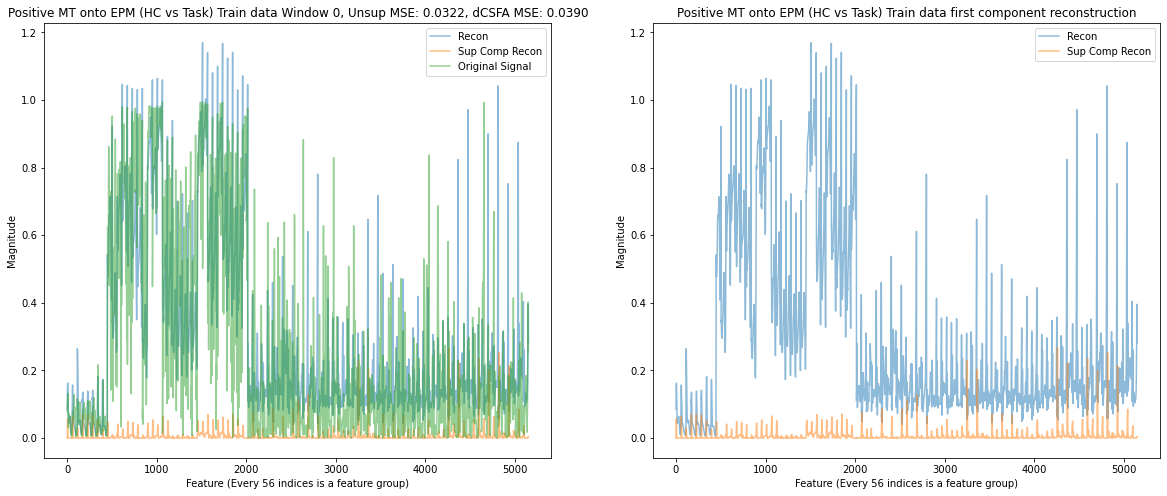

In [94]:
umc_dt.make_recon_plots(model,X_train,0,task="Positive MT onto EPM (HC vs Task) Train",saveFile="Boosted_Power.png")

## EPM Performance

In [12]:
y_pred, s = model.predict(X_train,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,y_in_task_mask_train,y_mouse_train)
print("Training ROC AUCs: ",roc_auc_dict)
mw_auc_dict = umc_dt.lpne_auc(y_pred,y_in_task_mask_train,y_mouse_train,s,True)
print("Training Mann Whitney AUCs: ",mw_auc_dict)
df = umc_dt.make_projection_csv(EPM_TRAIN_FILE,model,FEATURE_VECTOR,
                                ['y_mouse','y_expDate','y_time','y_Homecage','y_ROI','y_vel','y_locx','y_locy'],
                                save_file =".\\PosNeg_Results\\{}_MT_onto_EPM_Train_Projection_2022_April_24.csv".format(NETWORK_CONSTRAINT),
                                auc_dict=mw_auc_dict)
                                
y_pred, s = model.predict(X_val,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,y_in_task_mask_val,y_mouse_val)
print("Validation ROC AUCs: ",roc_auc_dict)
mw_auc_dict = umc_dt.lpne_auc(y_pred,y_in_task_mask_val,y_mouse_val,s,True)
print("Validation MW AUCs: ",mw_auc_dict)

df = umc_dt.make_projection_csv(EPM_VAL_FILE,model,FEATURE_VECTOR,
                                ['y_mouse','y_expDate','y_time','y_Homecage','y_ROI','y_vel','y_locx','y_locy'],
                                save_file =".\\PosNeg_Results\\{}_MT_onto_EPM_Val_Projection_2022_April_24.csv".format(NETWORK_CONSTRAINT),
                                auc_dict=mw_auc_dict)

Training ROC AUCs:  {'auc_method': 'sklearn_roc_auc', 'Mouse04201': 0.9790419161676647, 'Mouse04202': 0.7115282483289076, 'Mouse04205': 0.5833333333333333, 'Mouse04215': 0.5101307005700569, 'Mouse0630': 1.0, 'Mouse0634': 0.9959349593495934, 'Mouse0643': 1.0, 'Mouse1551': 1.0, 'Mouse39114': 0.609775641025641, 'Mouse39124': 0.5910153870340166, 'Mouse39133': 0.6557442820153199, 'Mouse6291': 1.0, 'Mouse6292': 1.0, 'Mouse6293': 1.0, 'Mouse69064': 0.6110730593607306, 'Mouse69074': 1.0, 'Mouse8580': 1.0, 'Mouse8581': 1.0, 'Mouse8582': 1.0, 'Mouse8891': 1.0, 'Mouse8894': 1.0}
Training Mann Whitney AUCs:  {'auc_method': 'mannWhitneyU', 'Mouse04201': (1.0, 1.948546217773956e-107), 'Mouse04202': (0.858263895247688, 3.3395965534169155e-57), 'Mouse04205': (0.6320987654320988, 0.19488016624660764), 'Mouse04215': (0.6425705070507051, 3.030906583402043e-10), 'Mouse0630': (1.0, 5.695515396295587e-84), 'Mouse0634': (1.0, 7.095752964106866e-68), 'Mouse0643': (1.0, 1.062145166618735e-49), 'Mouse1551': (1.

In [17]:
y_pred, s = model.predict(X_train,include_scores=True)
roc_mean,roc_std = umc_dt.get_mean_std_err_auc(y_pred,y_in_task_mask_train,y_mouse_train)
print("train roc auc mean: %0.2f +/- %0.2f"%(roc_mean,roc_std))
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,y_in_task_mask_train,y_mouse_train,s,True)
print("train roc auc mean: %0.2f +/- %0.2f"%(roc_mean,roc_std))
y_pred, s = model.predict(X_val,include_scores=True)
roc_mean,roc_std = umc_dt.get_mean_std_err_auc(y_pred,y_in_task_mask_val,y_mouse_val)
print("val roc auc mean: %0.2f +/- %0.2f"%(roc_mean,roc_std))
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,y_in_task_mask_val,y_mouse_val,s,True)
print("val mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))

train roc auc mean: 1.00 +/- 0.00
train roc auc mean: 1.00 +/- 0.00
val roc auc mean: 0.67 +/- 0.02
val mw auc mean: 0.74 +/- 0.03


In [13]:
#umc_dt.make_recon_plots(model,X_train,0,task="MT onto EPM (HC vs Task) Train",saveFile="flipped_mt_onto_epm_train_recon.png")
#umc_dt.make_recon_plots(model,X_val,0,task="MT onto EPM (HC vs Task) val",saveFile="flipped_mt_onto_epm_val_recon.png")
#df = make_projection_csv(EPM_TRAIN_FILE,model,FEATURE_VECTOR,
#                    ['y_mouse','y_expDate','y_time','y_Homecage','y_ROI','y_vel'],
#                    save_file = r".\\flipped_MT_onto_EPM_HC_vs_Task_Train_Projection_2022_March_25.csv")
#
#df = make_projection_csv(EPM_VAL_FILE,model,FEATURE_VECTOR,
#                    ['y_mouse','y_expDate','y_time','y_Homecage','y_ROI','y_vel'],
#                    save_file = r".\\flipped_MT_onto_EPM_HC_vs_Task_Val_Projection_2022_March_25.csv")

### FLX Performance

In [21]:

FULL_FEATURE_LIST = ["X_power_1_2_full","X_coh_1_2_full","X_gc_1_2_full"]
y_pred, s = model.predict(flx_X_train,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,flx_y_train,flx_y_mouse_train)
print("Training ROC AUCs: ",roc_auc_dict)
mw_auc_dict = umc_dt.lpne_auc(y_pred,flx_y_train,flx_y_mouse_train,s,True)
print("Training Mann Whitney AUCs: ",mw_auc_dict)

#df = umc_dt.make_projection_csv(FLX_TRAIN_FILE,model,FULL_FEATURE_LIST,
#                    ['y_mouse_full','y_expDate_full','y_time_full','y_flx_full'],
#                    save_file = ".\\PosNeg_Results\\{}_MT_onto_FLX_flx_vs_saline_Train_Projection_2022_April_24.csv".format(NETWORK_CONSTRAINT),
#                    auc_dict=mw_auc_dict,mousevar="y_mouse_full")

y_pred, s = model.predict(flx_X_validation,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,flx_y_validation,flx_y_mouse_validation)
print("Validation ROC AUCs: ",roc_auc_dict)
mw_auc_dict = umc_dt.lpne_auc(y_pred,flx_y_validation,flx_y_mouse_validation,s,True)
print("Validation MW AUCs: ",mw_auc_dict)

#df = umc_dt.make_projection_csv(FLX_VAL_FILE,model,FULL_FEATURE_LIST,
#                    ['y_mouse_full','y_expDate_full','y_time_full','y_flx_full'],
#                    save_file = ".\\PosNeg_Results\\{}_MT_onto_FLX_flx_vs_saline_Val_Projection_2022_April_24.csv".format(NETWORK_CONSTRAINT),
#                    auc_dict=mw_auc_dict,mousevar="y_mouse_full")

Training ROC AUCs:  {'auc_method': 'sklearn_roc_auc', 'Mouse3191': 0.9965677768756157, 'Mouse3193': 0.989438576987215, 'Mouse3194': 0.9975418784440592, 'Mouse3202': nan, 'Mouse3203': 0.9837536812991093, 'Mouse99003': nan}
Mouse  Mouse3202  has only one class - AUC cannot be calculated
n_positive samples  1504
n_negative samples  0
Mouse  Mouse99003  has only one class - AUC cannot be calculated
n_positive samples  1874
n_negative samples  0
Training Mann Whitney AUCs:  {'auc_method': 'mannWhitneyU', 'Mouse3191': (0.9991659743439224, 0.0), 'Mouse3193': (1.0, 0.0), 'Mouse3194': (0.9994553441997593, 0.0), 'Mouse3202': (nan, nan), 'Mouse3203': (0.9997077631583442, 0.0), 'Mouse99003': (nan, nan)}
Validation ROC AUCs:  {'auc_method': 'sklearn_roc_auc', 'Mouse3192': 0.6009733254878886}
Validation MW AUCs:  {'auc_method': 'mannWhitneyU', 'Mouse3192': (0.719342392370305, 2.0675679240208986e-114)}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,


In [20]:
umc_dt.lpne_auc(y_pred,~flx_y_validation.astype(bool),flx_y_mouse_validation,s,True)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1709 but corresponding boolean dimension is 3644

In [18]:
y_pred, s = model.predict(flx_X_train,include_scores=True)
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,~flx_y_train,flx_y_mouse_train,s,True)
print("train mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))
y_pred, s = model.predict(flx_X_validation,include_scores=True)
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,~flx_y_validation,flx_y_mouse_validation,s,True)
print("val mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))

Mouse  Mouse3191  has only one class - AUC cannot be calculated
n_positive samples  0
n_negative samples  0
Mouse  Mouse3193  has only one class - AUC cannot be calculated
n_positive samples  0
n_negative samples  0
Mouse  Mouse3194  has only one class - AUC cannot be calculated
n_positive samples  0
n_negative samples  0
Mouse  Mouse3202  has only one class - AUC cannot be calculated
n_positive samples  0
n_negative samples  0
Mouse  Mouse3203  has only one class - AUC cannot be calculated
n_positive samples  0
n_negative samples  0
Mouse  Mouse99003  has only one class - AUC cannot be calculated
n_positive samples  0
n_negative samples  0
train mw auc mean: nan +/- nan
Mouse  Mouse3192  has only one class - AUC cannot be calculated
n_positive samples  0
n_negative samples  0
val mw auc mean: nan +/- nan


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/hpc/home/mk423/Anxiety/Universal-Mouse-Code/umc_data_tools.py:274: RuntimeWarning: invalid value encountered in sqrt
  std = np.std(auc_list) / np.sqrt(len(auc_list)-1)


In [ ]:
umc_dt.make_recon_plots(model,flx_X_train,0,task="MT onto FLX Train",saveFile="ds_mt_onto_flx_train_recon.png")
umc_dt.make_recon_plots(model,flx_X_validation,0,task="MT onto FLX val",saveFile="ds_mt_onto_flx_val_recon.png")
df = make_projection_csv(FLX_TRAIN_FILE,model,FEATURE_VECTOR,
                    ['y_mouse','y_expDate','y_time','y_flx'],
                    save_file = r".\\DS_MT_onto_FLX_flx_vs_saline_Train_Projection_2022_March_25.csv")

df = make_projection_csv(FLX_VAL_FILE,model,FEATURE_VECTOR,
                    ['y_mouse','y_expDate','y_time','y_flx'],
                    save_file = r".\\DS_MT_onto_FLX_flx_vs_saline_Val_Projection_2022_March_25.csv")

## OFT Performance

In [16]:
oft_X_train[np.isnan(oft_X_train)] = 0

In [15]:
np.sum(np.isnan(oft_X_val))

0

In [8]:
y_pred, s = model.predict(oft_X_train,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,oft_y_task_train,oft_y_mouse_train)
print("Training ROC AUCs: ",roc_auc_dict)
mw_auc_dict = umc_dt.lpne_auc(y_pred,oft_y_task_train,oft_y_mouse_train,s,True)
print("Training Mann Whitney AUCs: ",mw_auc_dict)

y_pred, s = model.predict(oft_X_val,include_scores=True)
roc_auc_dict = umc_dt.lpne_auc(y_pred,oft_y_task_val,oft_y_mouse_val)
print("Validation ROC AUCs: ",roc_auc_dict)
mw_auc_dict = umc_dt.lpne_auc(y_pred,oft_y_task_val,oft_y_mouse_val,s,True)
print("Validation MW AUCs: ",mw_auc_dict)

Training ROC AUCs:  {'auc_method': 'sklearn_roc_auc', 'Mouse04191': 1.0, 'Mouse04201': 0.99822695035461, 'Mouse04202': 1.0, 'Mouse04205': 1.0, 'Mouse04215': nan, 'Mouse3191': 0.9847133685971337, 'Mouse3192': nan, 'Mouse3193': 0.9968220338983051, 'Mouse3194': nan, 'Mouse3203': nan, 'Mouse39114': 1.0, 'Mouse39124': 1.0, 'Mouse39133': 0.9984276729559749, 'Mouse69064': 0.9985029940119761, 'Mouse69072': 1.0, 'Mouse69074': 0.9981818181818182}
Mouse  Mouse04215  has only one class - AUC cannot be calculated
n_positive samples  506
n_negative samples  0
Mouse  Mouse3192  has only one class - AUC cannot be calculated
n_positive samples  279
n_negative samples  0
Mouse  Mouse3194  has only one class - AUC cannot be calculated
n_positive samples  324
n_negative samples  0
Mouse  Mouse3203  has only one class - AUC cannot be calculated
n_positive samples  500
n_negative samples  0
Training Mann Whitney AUCs:  {'auc_method': 'mannWhitneyU', 'Mouse04191': (1.0, 2.3405065517684796e-76), 'Mouse04201':

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,


In [9]:
y_pred, s = model.predict(oft_X_train,include_scores=True)
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,oft_y_task_train.astype(bool),oft_y_mouse_train,s,True)
print("train mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))

y_pred, s = model.predict(oft_X_val,include_scores=True)
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,oft_y_task_val.astype(bool),oft_y_mouse_val,s,True)
print("val mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))

Mouse  Mouse04215  has only one class - AUC cannot be calculated
n_positive samples  506
n_negative samples  0
Mouse  Mouse3192  has only one class - AUC cannot be calculated
n_positive samples  279
n_negative samples  0
Mouse  Mouse3194  has only one class - AUC cannot be calculated
n_positive samples  324
n_negative samples  0
Mouse  Mouse3203  has only one class - AUC cannot be calculated
n_positive samples  500
n_negative samples  0
train mw auc mean: 1.00 +/- 0.00
val mw auc mean: 0.80 +/- 0.06


In [12]:
y_pred, s = model.predict(oft_X_train,include_scores=True)
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,oft_y_task_train.astype(bool),oft_y_mouse_train,s,True)
print("train mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))

df = umc_dt.make_projection_csv(OFT_TRAIN_FILE,model,FEATURE_VECTOR,
                    ['y_mouse','y_expDate','y_time','y_Homecage','y_ROI','y_vel'],
                    save_file = ".\\PosNeg_Results\\{}_MT_onto_OFT_HC_vs_Task_Train_Projection_2022_April_24.csv".format(NETWORK_CONSTRAINT),
                    auc_dict=mw_auc_dict)

y_pred, s = model.predict(oft_X_val,include_scores=True)
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred,oft_y_task_val.astype(bool),oft_y_mouse_val,s,True)
print("val mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))

df = umc_dt.make_projection_csv(OFT_VAL_FILE,model,FEATURE_VECTOR,
                    ['y_mouse','y_expDate','y_time','y_Homecage','y_ROI','y_vel'],
                    save_file = ".\\PosNeg_Results\\{}_MT_onto_OFT_HC_vs_Task_Val_Projection_2022_April_24.csv".format(NETWORK_CONSTRAINT),
                    auc_dict=mw_auc_dict)

Mouse  Mouse04215  has only one class - AUC cannot be calculated
n_positive samples  506
n_negative samples  0
Mouse  Mouse3192  has only one class - AUC cannot be calculated
n_positive samples  279
n_negative samples  0
Mouse  Mouse3194  has only one class - AUC cannot be calculated
n_positive samples  324
n_negative samples  0
Mouse  Mouse3203  has only one class - AUC cannot be calculated
n_positive samples  500
n_negative samples  0
train mw auc mean: 0.00 +/- 0.00
val mw auc mean: 0.18 +/- 0.05


Mouse  Mouse04215  has only one class - AUC cannot be calculated
n_positive samples  506
n_negative samples  0
Mouse  Mouse3192  has only one class - AUC cannot be calculated
n_positive samples  279
n_negative samples  0
Mouse  Mouse3194  has only one class - AUC cannot be calculated
n_positive samples  324
n_negative samples  0
Mouse  Mouse3203  has only one class - AUC cannot be calculated
n_positive samples  500
n_negative samples  0
train mw auc mean: 0.00 +/- 0.00
val mw auc mean: 0.26 +/- 0.02


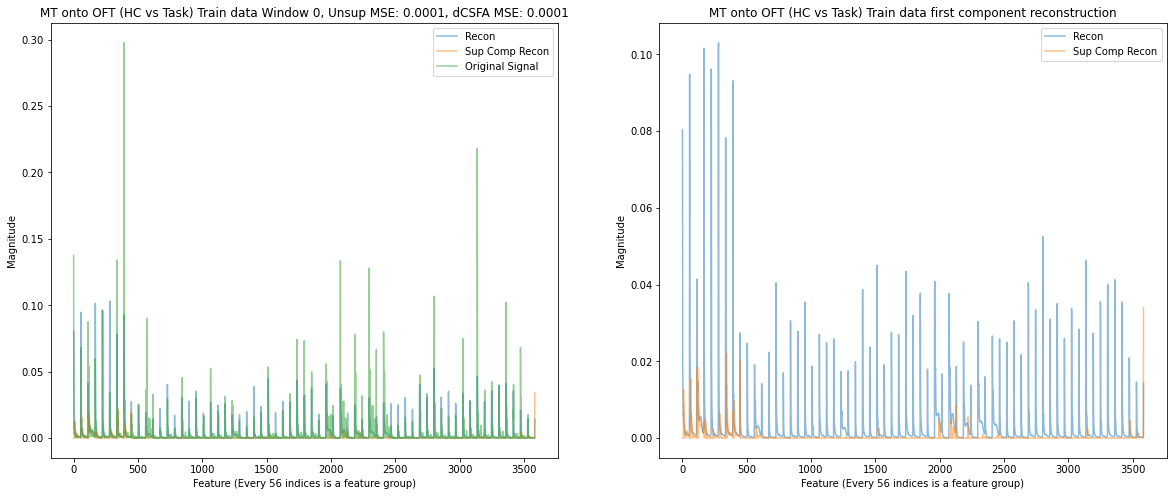

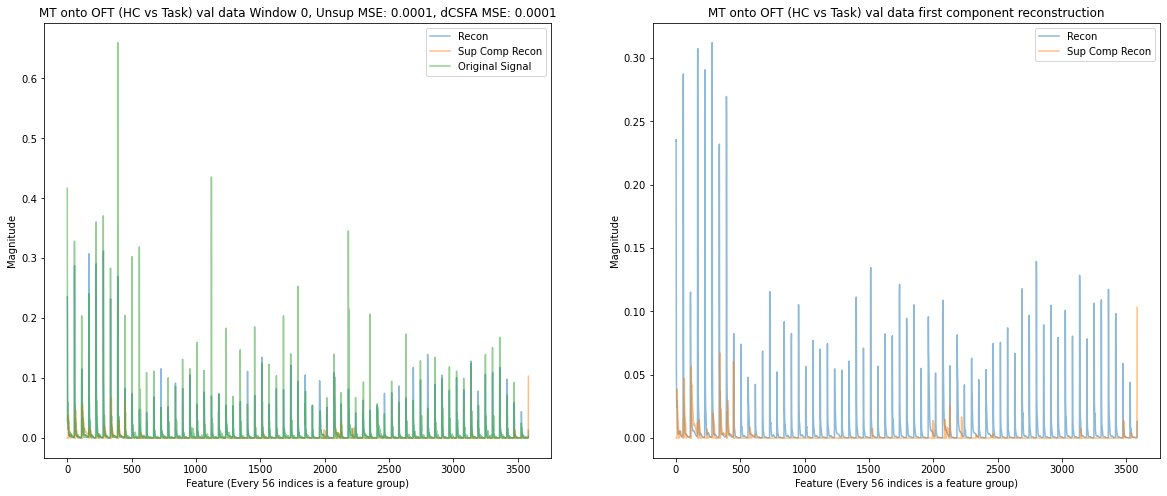

In [42]:


umc_dt.make_recon_plots(model,oft_X_train,0,task="MT onto OFT (HC vs Task) Train",saveFile="ds_mt_onto_oft_train_recon.png")
umc_dt.make_recon_plots(model,oft_X_val,0,task="MT onto OFT (HC vs Task) val",saveFile="ds_mt_onto_oft_val_recon.png")
df = make_projection_csv(OFT_TRAIN_FILE,model,FEATURE_VECTOR,
                    ['y_mouse','y_expDate','y_time','y_Homecage','y_ROI','y_vel'],
                    save_file = r".\\DS_MT_onto_OFT_HC_vs_Task_Train_Projection_2022_March_25.csv")

df = make_projection_csv(OFT_VAL_FILE,model,FEATURE_VECTOR,
                    ['y_mouse','y_expDate','y_time','y_Homecage','y_ROI','y_vel'],
                    save_file = r".\\DS_MT_onto_OFT_HC_vs_Task_Val_Projection_2022_March_25.csv")

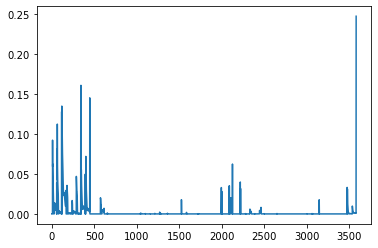

In [46]:
plt.plot(model.get_W_nmf().cpu().detach().numpy()[0,:])